In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import itertools

from sklearn.linear_model import LinearRegression

In [2]:
pd.options.display.max_columns = None #Знімаємо обмеження по к-сті стовпців

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/VasiaPiven/covid19_ua/master/covid19_by_area_type_hosp_dynamics.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583171 entries, 0 to 583170
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   zvit_date                    583171 non-null  object
 1   registration_area            583171 non-null  object
 2   is_required_hospitalization  583171 non-null  object
 3   person_gender                583171 non-null  object
 4   person_age_group             583171 non-null  object
 5   add_conditions               583171 non-null  object
 6   is_medical_worker            583171 non-null  object
 7   new_susp                     583171 non-null  int64 
 8   new_confirm                  583171 non-null  int64 
 9   active_confirm               583171 non-null  int64 
 10  new_death                    583171 non-null  int64 
 11  new_recover                  583171 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 53.4+ MB


In [5]:
data_correlation = data.groupby('registration_area').corr(method='pearson')

In [6]:
data_correlation

new_susp  new_confirm  active_confirm  \
registration_area                                                         
Івано-Франківська new_susp        1.000000     0.753464        0.763138   
                  new_confirm     0.753464     1.000000        0.748659   
                  active_confirm  0.763138     0.748659        1.000000   
                  new_death       0.046910     0.053296        0.063123   
                  new_recover     0.516211     0.527659        0.648215   
...                                    ...          ...             ...   
м. Київ           new_susp        1.000000     0.957879        0.754748   
                  new_confirm     0.957879     1.000000        0.773522   
                  active_confirm  0.754748     0.773522        1.000000   
                  new_death      -0.010673    -0.008770       -0.017256   
                  new_recover     0.733291     0.709280        0.762837   

                                  new_death  new_recover  
registration_area                                         
Івано-Франківська new_susp         0.046910     0.516211  
                  new_confirm      0.053296     0.527659  
                  active_confirm   0.063123     0.648215  
                  new_death        1.000000     0.032083  
                  new_recover      0.032083     1.000000  
...                                     ...          ...  
м. Київ           new_susp        -0.010673     0.733291  
                  new_confirm     -0.008770     0.709280  
                  active_confirm  -0.017256     0.762837  
                  new_death        1.000000    -0.024898  
                  new_recover     -0.024898     1.000000  

[125 rows x 5 columns]

In [7]:
def date_converter(date_):
    return datetime.strptime(date_, '%Y-%m-%d').date()

In [8]:
df = pd.read_csv('data/covid19_by_settlement_dynamics.csv', 
                 usecols=[
                     'zvit_date',
                     'registration_area',
                     'active_confirm'
                 ],
                 converters={
                     'zvit_date': date_converter
                 })

In [9]:
df_areas_timeline = df.groupby(['zvit_date', 'registration_area']).sum().pivot_table('active_confirm', 'zvit_date', 'registration_area')

In [10]:
df_areas_timeline = df_areas_timeline.dropna()

In [11]:
df_areas_timeline.index = pd.to_datetime(df_areas_timeline.index)

In [12]:
cities = df_areas_timeline.columns.values

In [13]:
df_1 = pd.DataFrame(columns=cities, index=cities).astype(float)
df_2 = pd.DataFrame(columns=cities, index=cities).astype(float)

In [14]:
def calculate_lag_correlation(col1: pd.Series, col2: pd.Series, lag_from: int, lag_to: int) -> [int, float]:

    def cross_corr(data_x, data_y, lag):
        return data_x.corr(data_y.shift(lag))

    corr_res = [cross_corr(col1, col2, lag=i) for i in range(lag_from, lag_to+1)]
    res = max(enumerate(corr_res, start=lag_from), key=lambda x: x[1])
    return res

In [15]:
for city1 in df_areas_timeline:
    for city2 in df_areas_timeline:
        res = calculate_lag_correlation(df_areas_timeline[city1], df_areas_timeline[city2], -50, 50)
        df_1[city1][city2] = res[1]
        df_2[city1][city2] = res[0]

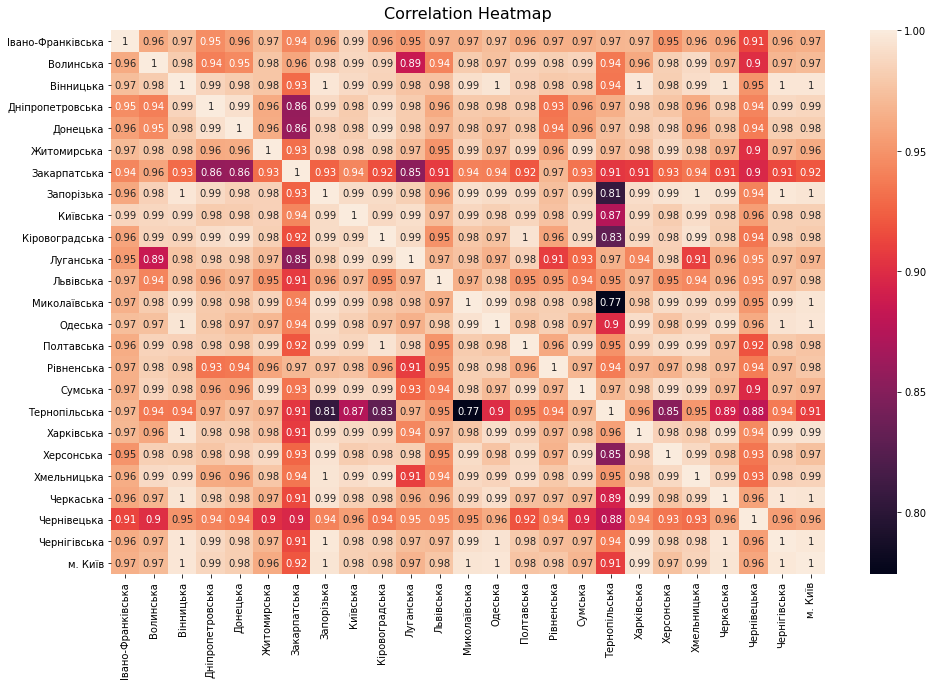

In [16]:
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df_1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=12);

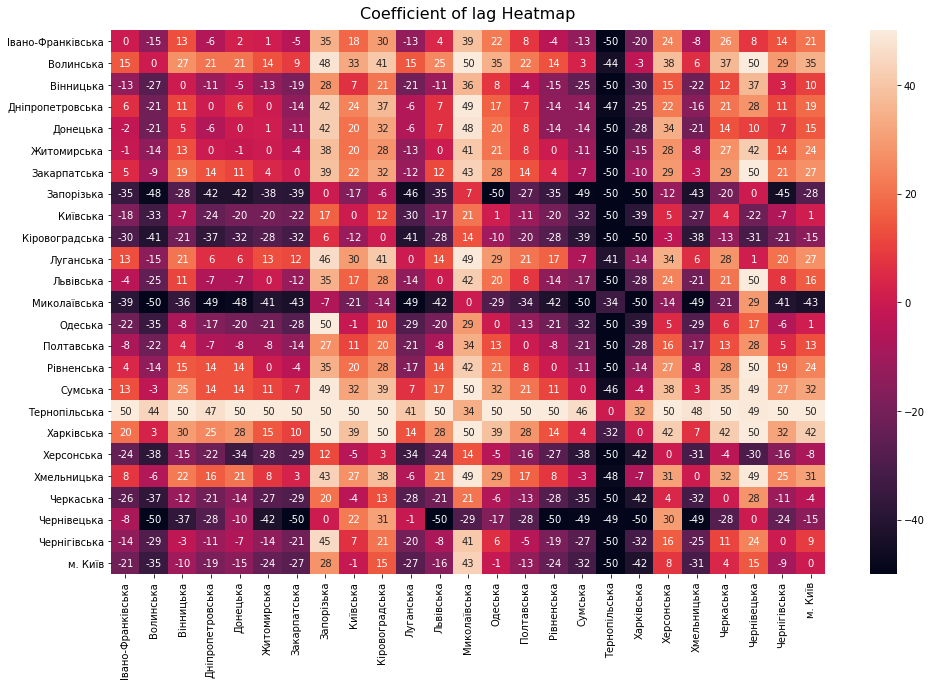

In [17]:
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df_2, annot=True)
heatmap.set_title('Coefficient of lag Heatmap', fontdict={'fontsize':16}, pad=12);